In [9]:
#!pip install xport

#!pip install --upgrade pandas

#!python -m venv myenv

#!myenv\Scripts\activate

#!pip install pandas xport

#!pip install scipy

import pandas as pd
import numpy as np
import xport

# Invasive Laboratory data:

In [10]:
import sklearn
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

In [11]:
# function to filter out columns and rows with too many NAs, threshold is 50% NAs in either the column or the row:
def naFilter(dataset):
    for i in dataset:
        if dataset[i].isna().sum()/len(dataset) > 0.5:
            dataset = dataset.drop(i, axis='columns')
    for i in range(len(dataset)):
        if dataset.loc[i].isna().sum()/len(dataset.loc[i]) > 0.5:
            dataset = dataset.drop(i)
    return dataset

# function to extract categorical and numerical column names
def catNamesAndNumNames(dataset):
    catNames = []
    numNames = []
    for i in dataset:
        if i == 'Anemia':
            pass
        elif len(pd.unique(dataset[i])) < 11:
                catNames.append(i)
        else:
            numNames.append(i)
    return catNames, numNames

In [12]:
# import demographics + hemoglobin data from 2017/2018
with open('2017-2018/CBC_J.XPT', 'rb') as f:
    hemo1 = pd.read_sas(f, format='xport')

with open('2017-2018/DEMO_J.XPT', 'rb') as f:
    demo1 = pd.read_sas(f, format='xport')

# import lab data from 2017/2018
# Chromium and cobalt
with open('2017-2018/CRCO_J.XPT', 'rb') as f:
    crco1 = pd.read_sas(f, format='xport')

# Lead, Cadmium, Total Mercury, Selenium, & Manganese - Blood
with open('2017-2018/PBCD_J.XPT', 'rb') as f:
    pbcd1 = pd.read_sas(f, format='xport')

# Mercury: Inorganic, Ethyl and Methyl - Blood
with open('2017-2018/IHGEM_J.XPT', 'rb') as f:
    ihgem1 = pd.read_sas(f, format='xport')

# insulin
with open('2017-2018/INS_J.XPT', 'rb') as f:
    ins1 = pd.read_sas(f, format='xport')

# Volatile Organic Compounds and Trihalomethanes/MTBE - Blood
with open('2017-2018/VOCWB_J.XPT', 'rb') as f:
    vocwb1 = pd.read_sas(f, format='xport')

# Cholesterol - Low-Density Lipoproteins (LDL) & Triglycerides
with open('2017-2018/TRIGLY_J.XPT', 'rb') as f:
    trigly1 = pd.read_sas(f, format='xport')
    
# Cholesterol - High - Density Lipoprotein (HDL)
with open('2017-2018/HDL_J.XPT', 'rb') as f:
    hdl1 = pd.read_sas(f, format='xport')
    
# Vitamin D
with open('2017-2018/VID_J.XPT', 'rb') as f:
    vid1 = pd.read_sas(f, format='xport')
    
# More Datasets from 2015-2016 to supplement our study:
with open('2015-2016/CBC_I.XPT', 'rb') as f:
    hemo2 = pd.read_sas(f, format='xport')

with open('2015-2016/DEMO_I.XPT', 'rb') as f:
    demo2 = pd.read_sas(f, format='xport')

# Chromium and cobalt
with open('2015-2016/CRCO_I.XPT', 'rb') as f:
    crco2 = pd.read_sas(f, format='xport')

# Lead, Cadmium, Total Mercury, Selenium, & Manganese - Blood
with open('2015-2016/PBCD_I.XPT', 'rb') as f:
    pbcd2 = pd.read_sas(f, format='xport')

# Mercury: Inorganic, Ethyl and Methyl - Blood
with open('2015-2016/IHGEM_I.XPT', 'rb') as f:
    ihgem2 = pd.read_sas(f, format='xport')

# insulin
with open('2015-2016/INS_I.XPT', 'rb') as f:
    ins2 = pd.read_sas(f, format='xport')

# Volatile Organic Compounds and Trihalomethanes/MTBE - Blood
with open('2015-2016/VOCWB_I.XPT', 'rb') as f:
    vocwb2 = pd.read_sas(f, format='xport')

# Cholesterol - Low-Density Lipoproteins (LDL) & Triglycerides
with open('2015-2016/TRIGLY_I.XPT', 'rb') as f:
    trigly2 = pd.read_sas(f, format='xport')
    
# Cholesterol - High - Density Lipoprotein (HDL)
with open('2015-2016/HDL_I.XPT', 'rb') as f:
    hdl2 = pd.read_sas(f, format='xport')
    
# Vitamin D
with open('2015-2016/VID_I.XPT', 'rb') as f:
    vid2 = pd.read_sas(f, format='xport')


In [13]:
hemo1

,SEQN,LBXWBCSI,LBXLYPCT,LBXMOPCT,LBXNEPCT,LBXEOPCT,LBXBAPCT,LBDLYMNO,LBDMONO,LBDNENO,...,LBXRBCSI,LBXHGB,LBXHCT,LBXMCVSI,LBXMCHSI,LBXMC,LBXRDW,LBXPLTSI,LBXMPSI,LBXNRBC
0,93703.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,93704.0,7.4,47.8,8.0,42.6,1.0,0.7,3.5,0.6,3.2,...,4.25,13.1,37.0,87.0,30.8,35.4,12.8,239.0,8.6,1.000000e-01
2,93705.0,8.6,40.0,7.4,48.8,2.9,1.0,3.4,0.6,4.2,...,5.48,11.9,36.7,67.0,21.7,32.4,15.6,309.0,7.9,5.397605e-79
3,93706.0,6.1,24.6,9.1,61.4,4.3,0.8,1.5,0.6,3.7,...,5.24,16.3,47.0,89.7,31.1,34.7,12.2,233.0,6.6,5.397605e-79
4,93707.0,11.2,37.1,6.2,54.7,1.6,0.5,4.2,0.7,6.1,...,5.02,14.5,42.1,83.9,28.9,34.4,13.6,348.0,8.5,2.000000e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8361,102952.0,5.1,34.9,7.1,56.2,1.3,0.6,1.8,0.4,2.9,...,4.64,13.4,40.6,87.7,29.0,33.1,13.3,161.0,9.1,5.000000e-01
8362,102953.0,8.3,28.3,6.8,60.8,3.6,0.6,2.3,0.6,5.0,...,5.01,15.5,44.4,88.8,30.9,34.8,13.6,227.0,8.7,1.000000e-01
8363,102954.0,5.1,43.5,11.8,39.9,3.5,1.4,2.2,0.6,2.0,...,3.72,6.4,23.1,61.9,17.3,27.9,19.6,145.0,9.7,1.000000e-01
8364,102955.0,11.4,33.4,7.3,57.5,1.1,0.9,3.8,0.8,6.6,...,4.93,11.4,33.7,68.4,23.1,33.7,17.4,382.0,7.7,1.000000e-01


In [14]:
hemo1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8366 entries, 0 to 8365
Data columns (total 22 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SEQN      8366 non-null   float64
 1   LBXWBCSI  7528 non-null   float64
 2   LBXLYPCT  7523 non-null   float64
 3   LBXMOPCT  7523 non-null   float64
 4   LBXNEPCT  7523 non-null   float64
 5   LBXEOPCT  7523 non-null   float64
 6   LBXBAPCT  7523 non-null   float64
 7   LBDLYMNO  7523 non-null   float64
 8   LBDMONO   7523 non-null   float64
 9   LBDNENO   7523 non-null   float64
 10  LBDEONO   7523 non-null   float64
 11  LBDBANO   7523 non-null   float64
 12  LBXRBCSI  7528 non-null   float64
 13  LBXHGB    7528 non-null   float64
 14  LBXHCT    7528 non-null   float64
 15  LBXMCVSI  7528 non-null   float64
 16  LBXMCHSI  7528 non-null   float64
 17  LBXMC     7528 non-null   float64
 18  LBXRDW    7528 non-null   float64
 19  LBXPLTSI  7528 non-null   float64
 20  LBXMPSI   7528 non-null   floa

In [15]:
demo1.head()

,SEQN,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,...,DMDHREDZ,DMDHRMAZ,DMDHSEDZ,WTINT2YR,WTMEC2YR,SDMVPSU,SDMVSTRA,INDHHIN2,INDFMIN2,INDFMPIR
0,93703.0,10.0,2.0,2.0,2.0,NaN,5.0,6.0,2.0,27.0,...,3.0,1.0,3.0,9246.491865,8539.731348,2.0,145.0,15.0,15.0,5.00
1,93704.0,10.0,2.0,1.0,2.0,NaN,3.0,3.0,1.0,33.0,...,3.0,1.0,2.0,37338.768343,42566.614750,1.0,143.0,15.0,15.0,5.00
2,93705.0,10.0,2.0,2.0,66.0,NaN,4.0,4.0,2.0,NaN,...,1.0,2.0,NaN,8614.571172,8338.419786,2.0,145.0,3.0,3.0,0.82
3,93706.0,10.0,2.0,1.0,18.0,NaN,5.0,6.0,2.0,222.0,...,3.0,1.0,2.0,8548.632619,8723.439814,2.0,134.0,NaN,NaN,NaN
4,93707.0,10.0,2.0,1.0,13.0,NaN,5.0,7.0,2.0,158.0,...,2.0,1.0,3.0,6769.344567,7064.609730,1.0,138.0,10.0,10.0,1.88


In [16]:
demo1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9254 entries, 0 to 9253
Data columns (total 46 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SEQN      9254 non-null   float64
 1   SDDSRVYR  9254 non-null   float64
 2   RIDSTATR  9254 non-null   float64
 3   RIAGENDR  9254 non-null   float64
 4   RIDAGEYR  9254 non-null   float64
 5   RIDAGEMN  597 non-null    float64
 6   RIDRETH1  9254 non-null   float64
 7   RIDRETH3  9254 non-null   float64
 8   RIDEXMON  8704 non-null   float64
 9   RIDEXAGM  3433 non-null   float64
 10  DMQMILIZ  6004 non-null   float64
 11  DMQADFC   561 non-null    float64
 12  DMDBORN4  9254 non-null   float64
 13  DMDCITZN  9251 non-null   float64
 14  DMDYRSUS  1948 non-null   float64
 15  DMDEDUC3  2306 non-null   float64
 16  DMDEDUC2  5569 non-null   float64
 17  DMDMARTL  5569 non-null   float64
 18  RIDEXPRG  1110 non-null   float64
 19  SIALANG   9254 non-null   float64
 20  SIAPROXY  9254 non-null   floa

In [17]:
demo1 = demo1[['SEQN','DMDHRGND']]
demo1

,SEQN,DMDHRGND
0,93703.0,1.0
1,93704.0,1.0
2,93705.0,2.0
3,93706.0,1.0
4,93707.0,1.0
...,...,...
9249,102952.0,2.0
9250,102953.0,1.0
9251,102954.0,2.0
9252,102955.0,2.0


In [18]:
crco1

,SEQN,LBXBCR,LBDBCRSI,LBDBCRLC,LBXBCO,LBDBCOSI,LBDBCOLC
0,93705.0,0.29,5.58,1.000000e+00,0.20,3.39,5.397605e-79
1,93708.0,0.29,5.58,1.000000e+00,0.16,2.72,5.397605e-79
2,93709.0,0.70,13.46,5.397605e-79,0.34,5.77,5.397605e-79
3,93711.0,0.29,5.58,1.000000e+00,0.26,4.41,5.397605e-79
4,93713.0,0.29,5.58,1.000000e+00,0.12,2.04,5.397605e-79
...,...,...,...,...,...,...,...
3671,102946.0,0.29,5.58,1.000000e+00,0.15,2.55,5.397605e-79
3672,102947.0,0.29,5.58,1.000000e+00,0.34,5.77,5.397605e-79
3673,102952.0,0.29,5.58,1.000000e+00,0.15,2.55,5.397605e-79
3674,102953.0,0.67,12.88,5.397605e-79,0.12,2.04,5.397605e-79


In [19]:
crco1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3676 entries, 0 to 3675
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SEQN      3676 non-null   float64
 1   LBXBCR    3518 non-null   float64
 2   LBDBCRSI  3518 non-null   float64
 3   LBDBCRLC  3518 non-null   float64
 4   LBXBCO    3520 non-null   float64
 5   LBDBCOSI  3520 non-null   float64
 6   LBDBCOLC  3520 non-null   float64
dtypes: float64(7)
memory usage: 201.2 KB


In [20]:
pbcd1

,SEQN,LBXBPB,LBDBPBSI,LBDBPBLC,LBXBCD,LBDBCDSI,LBDBCDLC,LBXTHG,LBDTHGSI,LBDTHGLC,LBXBSE,LBDBSESI,LBDBSELC,LBXBMN,LBDBMNSI,LBDBMNLC
0,93703.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,93704.0,NaN,NaN,NaN,0.07,0.62,1.000000e+00,0.47,2.35,5.397605e-79,142.28,1.81,5.397605e-79,9.41,171.28,5.397605e-79
2,93705.0,2.98,0.14,5.397605e-79,0.24,2.14,5.397605e-79,1.07,5.34,5.397605e-79,185.71,2.36,5.397605e-79,8.57,155.99,5.397605e-79
3,93706.0,0.74,0.04,5.397605e-79,0.21,1.87,5.397605e-79,10.64,53.09,5.397605e-79,199.44,2.53,5.397605e-79,14.07,256.10,5.397605e-79
4,93707.0,0.39,0.02,5.397605e-79,0.14,1.25,5.397605e-79,0.20,1.00,1.000000e+00,179.34,2.28,5.397605e-79,12.60,229.35,5.397605e-79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8361,102952.0,0.75,0.04,5.397605e-79,0.61,5.43,5.397605e-79,0.65,3.24,5.397605e-79,164.18,2.09,5.397605e-79,16.81,305.98,5.397605e-79
8362,102953.0,1.12,0.05,5.397605e-79,0.21,1.87,5.397605e-79,0.62,3.09,5.397605e-79,195.21,2.48,5.397605e-79,8.34,151.80,5.397605e-79
8363,102954.0,0.46,0.02,5.397605e-79,0.32,2.85,5.397605e-79,2.08,10.38,5.397605e-79,164.46,2.09,5.397605e-79,8.76,159.45,5.397605e-79
8364,102955.0,0.25,0.01,5.397605e-79,0.11,0.98,5.397605e-79,0.20,1.00,1.000000e+00,184.00,2.34,5.397605e-79,21.76,396.08,5.397605e-79


In [21]:
pbcd1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8366 entries, 0 to 8365
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SEQN      8366 non-null   float64
 1   LBXBPB    6884 non-null   float64
 2   LBDBPBSI  6884 non-null   float64
 3   LBDBPBLC  6884 non-null   float64
 4   LBXBCD    7513 non-null   float64
 5   LBDBCDSI  7513 non-null   float64
 6   LBDBCDLC  7513 non-null   float64
 7   LBXTHG    7513 non-null   float64
 8   LBDTHGSI  7513 non-null   float64
 9   LBDTHGLC  7513 non-null   float64
 10  LBXBSE    7513 non-null   float64
 11  LBDBSESI  7513 non-null   float64
 12  LBDBSELC  7513 non-null   float64
 13  LBXBMN    7513 non-null   float64
 14  LBDBMNSI  7513 non-null   float64
 15  LBDBMNLC  7513 non-null   float64
dtypes: float64(16)
memory usage: 1.0 MB


In [22]:
ihgem1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8366 entries, 0 to 8365
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SEQN      8366 non-null   float64
 1   LBXIHG    7480 non-null   float64
 2   LBDIHGSI  7480 non-null   float64
 3   LBDIHGLC  7480 non-null   float64
 4   LBXBGE    7480 non-null   float64
 5   LBDBGESI  7480 non-null   float64
 6   LBDBGELC  7480 non-null   float64
 7   LBXBGM    7480 non-null   float64
 8   LBDBGMSI  7480 non-null   float64
 9   LBDBGMLC  7480 non-null   float64
dtypes: float64(10)
memory usage: 653.7 KB


In [23]:
ins1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3036 entries, 0 to 3035
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SEQN      3036 non-null   float64
 1   WTSAF2YR  3036 non-null   float64
 2   LBXIN     2825 non-null   float64
 3   LBDINSI   2825 non-null   float64
 4   LBDINLC   2825 non-null   float64
dtypes: float64(5)
memory usage: 118.7 KB


In [24]:
vocwb1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3172 entries, 0 to 3171
Data columns (total 82 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SEQN      3172 non-null   float64
 1   WTSVOC2Y  3172 non-null   float64
 2   LBX2DF    2866 non-null   float64
 3   LBD2DFLC  2866 non-null   float64
 4   LBX4CE    2866 non-null   float64
 5   LBD4CELC  2866 non-null   float64
 6   LBXV06    2696 non-null   float64
 7   LBDV06LC  2696 non-null   float64
 8   LBXV07N   2846 non-null   float64
 9   LBDV07LC  2846 non-null   float64
 10  LBXV08N   2863 non-null   float64
 11  LBDV08LC  2863 non-null   float64
 12  LBXV1D    2842 non-null   float64
 13  LBDV1DLC  2842 non-null   float64
 14  LBXV2A    2865 non-null   float64
 15  LBDV2ALC  2865 non-null   float64
 16  LBXV3B    2866 non-null   float64
 17  LBDV3BLC  2866 non-null   float64
 18  LBXV4C    2724 non-null   float64
 19  LBDV4CLC  2724 non-null   float64
 20  LBXVBF    2857 non-null   floa

In [25]:
trigly1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3036 entries, 0 to 3035
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SEQN      3036 non-null   float64
 1   WTSAF2YR  3036 non-null   float64
 2   LBXTR     2834 non-null   float64
 3   LBDTRSI   2834 non-null   float64
 4   LBDLDL    2808 non-null   float64
 5   LBDLDLSI  2808 non-null   float64
 6   LBDLDLM   2808 non-null   float64
 7   LBDLDMSI  2808 non-null   float64
 8   LBDLDLN   2827 non-null   float64
 9   LBDLDNSI  2827 non-null   float64
dtypes: float64(10)
memory usage: 237.3 KB


In [26]:
hdl1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7435 entries, 0 to 7434
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SEQN      7435 non-null   float64
 1   LBDHDD    6738 non-null   float64
 2   LBDHDDSI  6738 non-null   float64
dtypes: float64(3)
memory usage: 174.4 KB


In [27]:
vid1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8366 entries, 0 to 8365
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SEQN      8366 non-null   float64
 1   LBXVIDMS  7409 non-null   float64
 2   LBDVIDLC  7409 non-null   float64
 3   LBXVD2MS  7409 non-null   float64
 4   LBDVD2LC  7409 non-null   float64
 5   LBXVD3MS  7410 non-null   float64
 6   LBDVD3LC  7410 non-null   float64
 7   LBXVE3MS  7402 non-null   float64
 8   LBDVE3LC  7402 non-null   float64
dtypes: float64(9)
memory usage: 588.4 KB


In [28]:
combinedLabData17 = pd.merge(hemo1, demo1, on='SEQN', how='left')
combinedLabData17 = pd.merge(combinedLabData17, pbcd1, on='SEQN', how='left')
combinedLabData17 = pd.merge(combinedLabData17, ihgem1, on='SEQN', how='left')
combinedLabData17 = pd.merge(combinedLabData17, ins1, on='SEQN', how='left')
combinedLabData17 = pd.merge(combinedLabData17, vocwb1, on='SEQN', how='left')
combinedLabData17 = pd.merge(combinedLabData17, trigly1, on='SEQN', how='left')
combinedLabData17 = pd.merge(combinedLabData17, hdl1, on='SEQN', how='left')
combinedLabData17 = pd.merge(combinedLabData17, vid1, on='SEQN', how='left')

combinedLabData15 = pd.merge(hemo2, demo2, on='SEQN', how='left')
combinedLabData15 = pd.merge(combinedLabData15, pbcd2, on='SEQN', how='left')
combinedLabData15 = pd.merge(combinedLabData15, ihgem2, on='SEQN', how='left')
combinedLabData15 = pd.merge(combinedLabData15, ins2, on='SEQN', how='left')
combinedLabData15 = pd.merge(combinedLabData15, vocwb2, on='SEQN', how='left')
combinedLabData15 = pd.merge(combinedLabData15, trigly2, on='SEQN', how='left')
combinedLabData15 = pd.merge(combinedLabData15, hdl2, on='SEQN', how='left')
combinedLabData15 = pd.merge(combinedLabData15, vid2, on='SEQN', how='left')

In [29]:
combinedLabData = combinedLabData15.append(combinedLabData17, ignore_index = True)
combinedLabData = combinedLabData.reset_index()
combinedLabData = combinedLabData.drop(['index'], axis=1)

In [30]:
len(pd.unique(combinedLabData['SEQN']))

17531

In [31]:
combinedLabData.info

<bound method DataFrame.info of            SEQN  LBXWBCSI  LBXLYPCT  LBXMOPCT  LBXNEPCT  LBXEOPCT  LBXBAPCT  \
0       83732.0       9.8      23.9       8.2      63.5       4.0       0.5   
1       83733.0       7.3      31.3       9.7      54.8       2.6       1.8   
2       83734.0       4.4      29.9       9.6      55.8       3.9       0.9   
3       83735.0       6.1      17.1      10.3      68.7       3.1       0.9   
4       83736.0       4.2      47.1       7.8      44.8       0.2       0.2   
...         ...       ...       ...       ...       ...       ...       ...   
17526  102952.0       5.1      34.9       7.1      56.2       1.3       0.6   
17527  102953.0       8.3      28.3       6.8      60.8       3.6       0.6   
17528  102954.0       5.1      43.5      11.8      39.9       3.5       1.4   
17529  102955.0      11.4      33.4       7.3      57.5       1.1       0.9   
17530  102956.0       9.0      29.4       6.9      58.8       4.0       1.0   

       LBDLYMNO  LB

In [32]:
# Filtering our rows and columns that are more than 50% NAs
combinedLabData = naFilter(combinedLabData)

In [33]:
combinedLabData

,SEQN,LBXWBCSI,LBXLYPCT,LBXMOPCT,LBXNEPCT,LBXEOPCT,LBXBAPCT,LBDLYMNO,LBDMONO,LBDNENO,...,LBDHDD,LBDHDDSI,LBXVIDMS,LBDVIDLC,LBXVD2MS,LBDVD2LC,LBXVD3MS,LBDVD3LC,LBXVE3MS,LBDVE3LC
0,83732.0,9.8,23.9,8.2,63.5,4.0,0.5,2.3,0.8,6.2,...,46.0,1.19,76.1,5.397605e-79,1.45,1.0,74.7,5.397605e-79,4.70,5.397605e-79
1,83733.0,7.3,31.3,9.7,54.8,2.6,1.8,2.3,0.7,4.0,...,63.0,1.63,56.5,5.397605e-79,1.45,1.0,55.1,5.397605e-79,3.51,5.397605e-79
2,83734.0,4.4,29.9,9.6,55.8,3.9,0.9,1.3,0.4,2.5,...,30.0,0.78,87.5,5.397605e-79,1.45,1.0,86.1,5.397605e-79,8.89,5.397605e-79
3,83735.0,6.1,17.1,10.3,68.7,3.1,0.9,1.0,0.6,4.2,...,61.0,1.58,38.4,5.397605e-79,1.45,1.0,37.0,5.397605e-79,3.08,5.397605e-79
4,83736.0,4.2,47.1,7.8,44.8,0.2,0.2,2.0,0.3,1.9,...,53.0,1.37,58.7,5.397605e-79,1.45,1.0,57.3,5.397605e-79,3.33,5.397605e-79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17526,102952.0,5.1,34.9,7.1,56.2,1.3,0.6,1.8,0.4,2.9,...,60.0,1.55,82.7,5.397605e-79,1.45,1.0,81.3,5.397605e-79,5.43,5.397605e-79
17527,102953.0,8.3,28.3,6.8,60.8,3.6,0.6,2.3,0.6,5.0,...,49.0,1.27,49.5,5.397605e-79,1.45,1.0,48.1,5.397605e-79,2.73,5.397605e-79
17528,102954.0,5.1,43.5,11.8,39.9,3.5,1.4,2.2,0.6,2.0,...,54.0,1.40,50.5,5.397605e-79,1.45,1.0,49.1,5.397605e-79,2.97,5.397605e-79
17529,102955.0,11.4,33.4,7.3,57.5,1.1,0.9,3.8,0.8,6.6,...,34.0,0.88,61.9,5.397605e-79,1.45,1.0,60.5,5.397605e-79,3.97,5.397605e-79


In [34]:
# Extracting the categorical and numerical variables
catVars, numVars = catNamesAndNumNames(combinedLabData)
print(catVars)
print(numVars)

['LBDBANO', 'SDDSRVYR', 'RIDSTATR', 'RIAGENDR', 'RIDRETH1', 'RIDRETH3', 'RIDEXMON', 'DMDBORN4', 'DMDCITZN', 'SIALANG', 'SIAPROXY', 'SIAINTRP', 'FIALANG', 'FIAPROXY', 'FIAINTRP', 'DMDHHSIZ', 'DMDFMSIZ', 'DMDHHSZA', 'DMDHHSZB', 'DMDHHSZE', 'DMDHRGND', 'DMDHRBR4', 'DMDHREDU', 'DMDHRMAR', 'SDMVPSU', 'LBDBPBLC', 'LBDBCDLC', 'LBDTHGLC', 'LBDBSELC', 'LBDBMNLC', 'LBDIHGLC', 'LBDBGELC', 'LBDBGMLC', 'LBDVIDLC', 'LBDVD2LC', 'LBDVD3LC', 'LBDVE3LC']
['SEQN', 'LBXWBCSI', 'LBXLYPCT', 'LBXMOPCT', 'LBXNEPCT', 'LBXEOPCT', 'LBXBAPCT', 'LBDLYMNO', 'LBDMONO', 'LBDNENO', 'LBDEONO', 'LBXRBCSI', 'LBXHGB', 'LBXHCT', 'LBXMCVSI', 'LBXMCHSI', 'LBXMC', 'LBXRDW', 'LBXPLTSI', 'LBXMPSI', 'RIDAGEYR', 'DMDHRAGE', 'WTINT2YR', 'WTMEC2YR', 'SDMVSTRA', 'INDHHIN2', 'INDFMIN2', 'LBXBPB', 'LBDBPBSI', 'LBXBCD', 'LBDBCDSI', 'LBXTHG', 'LBDTHGSI', 'LBXBSE', 'LBDBSESI', 'LBXBMN', 'LBDBMNSI', 'LBXIHG', 'LBDIHGSI', 'LBXBGE', 'LBXBGM', 'LBDHDD', 'LBDHDDSI', 'LBXVIDMS', 'LBXVD2MS', 'LBXVD3MS', 'LBXVE3MS']


In [35]:
# Creating Datasets based on categorical or numeric columns
catlabdata = combinedLabData[catVars]
numlabdata = combinedLabData[numVars]


In [36]:
# for i in catVars:
#     plt.figure()
#     sns.set(font_scale=1)
#     sns.countplot(data=catlabdata, x = i)
#     plt.xlabel(i, fontsize=15)
#     plt.ylabel("Count", fontsize=15)
#     plt.show()

In [37]:
# for i in numVars:
#     plt.figure()
#     sns.set(font_scale=1)
#     sns.histplot(data=numlabdata, x = i)
#     plt.xlabel(i, fontsize=15)
#     plt.ylabel("Count", fontsize=15)
#     plt.show()

In [38]:

# Create an imputer object with a median filling strategy
imputer_num = SimpleImputer(missing_values=np.nan, strategy='median')
imputer_cat = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
# Apply the imputer to the numerical data
numlabdataimputed = pd.DataFrame(imputer_num.fit_transform(numlabdata), columns=numlabdata.columns)

# Impute missing values with the mode for each column
catlabdataimputed = pd.DataFrame(imputer_cat.fit_transform(catlabdata), columns=catlabdata.columns)

print(numlabdataimputed)
print(catlabdataimputed)

           SEQN  LBXWBCSI  LBXLYPCT  LBXMOPCT  LBXNEPCT  LBXEOPCT  LBXBAPCT  \
0       83732.0       9.8      23.9       8.2      63.5       4.0       0.5   
1       83733.0       7.3      31.3       9.7      54.8       2.6       1.8   
2       83734.0       4.4      29.9       9.6      55.8       3.9       0.9   
3       83735.0       6.1      17.1      10.3      68.7       3.1       0.9   
4       83736.0       4.2      47.1       7.8      44.8       0.2       0.2   
...         ...       ...       ...       ...       ...       ...       ...   
15607  102952.0       5.1      34.9       7.1      56.2       1.3       0.6   
15608  102953.0       8.3      28.3       6.8      60.8       3.6       0.6   
15609  102954.0       5.1      43.5      11.8      39.9       3.5       1.4   
15610  102955.0      11.4      33.4       7.3      57.5       1.1       0.9   
15611  102956.0       9.0      29.4       6.9      58.8       4.0       1.0   

       LBDLYMNO  LBDMONO  LBDNENO  ...  LBXIHG  LBD

In [39]:
# for i in catVars:
#     plt.figure()
#     sns.set(font_scale=1)
#     sns.countplot(data=catlabdataimputed, x = i)
#     plt.xlabel(i, fontsize=15)
#     plt.ylabel("Count", fontsize=15)
#     plt.show()

In [40]:
# for i in numVars:
#     plt.figure()
#     sns.set(font_scale=1)
#     sns.histplot(data=numlabdataimputed, x = i)
#     plt.xlabel(i, fontsize=15)
#     plt.ylabel("Count", fontsize=15)
#     plt.show()

In [41]:
combinedLabDataImputed = pd.concat([numlabdataimputed, catlabdataimputed], axis=1)
combinedLabDataImputed = pd.concat([combinedLabDataImputed, ], axis=1)
combinedLabDataImputed = naFilter(combinedLabDataImputed.reset_index())
combinedLabDataImputed = combinedLabDataImputed.reset_index()
combinedLabDataImputed = naFilter(combinedLabDataImputed)
combinedLabDataImputed = combinedLabDataImputed.drop(['level_0', 'index'], axis = 1)

In [42]:
corrMatrix = combinedLabDataImputed.corr().abs()
upper = corrMatrix.where(np.triu(np.ones(corrMatrix.shape), k=1).astype(np.bool))
toDrop = [column for column in upper.columns if any(upper[column] > 0.9)]
combinedLabDataImputed.drop(toDrop, axis=1, inplace=True)

<ipython-input-42-16e6ec1781e6>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corrMatrix.where(np.triu(np.ones(corrMatrix.shape), k=1).astype(np.bool))


In [43]:
# presplitting the data for final testing stage
combinedLabDataImputed, combinedLabDataImputed_final_test= train_test_split(combinedLabDataImputed, test_size=0.2, random_state=69)
combinedLabDataImputed = combinedLabDataImputed.reset_index().drop('index', axis=1)

In [44]:
print(combinedLabDataImputed.info)

<bound method DataFrame.info of            SEQN  LBXWBCSI  LBXLYPCT  LBXMOPCT  LBXEOPCT  LBXBAPCT  LBDLYMNO  \
0       90811.0       7.8      35.5       6.5       0.7       0.8       2.8   
1       89918.0       7.6      26.7      11.3       5.8       0.6       2.0   
2      102665.0      11.7      22.7      57.2       1.5       0.4       2.7   
3       96840.0       5.2      29.8       9.6       8.3       0.7       1.5   
4      102576.0       5.6      34.6       6.0       1.6       1.2       1.9   
...         ...       ...       ...       ...       ...       ...       ...   
12484   95757.0       7.9      39.3       5.8       6.6       1.0       3.1   
12485   97031.0       4.1      26.6       9.6       2.6       0.9       1.1   
12486   88729.0       8.0      20.1       9.4       1.8       0.8       1.6   
12487   92743.0       8.6      41.4       7.7       2.5       0.7       3.6   
12488  102705.0      10.0      27.5       6.2       1.5       0.6       2.8   

       LBDMONO  LBD

In [45]:
anemia = []
for i in range(len(combinedLabDataImputed)):
    if combinedLabDataImputed ['DMDHRGND'][i] == 1 and combinedLabDataImputed ['LBXHGB'][i] < 13:
        anemia.append('True')
    elif combinedLabDataImputed ['DMDHRGND'][i] == 2 and combinedLabDataImputed ['LBXHGB'][i] < 12:
        anemia.append('True')
    else:
        anemia.append('False')

In [46]:
combinedLabDataImputed_final_test = combinedLabDataImputed_final_test.reset_index().drop('index', axis=1)
combinedLabDataImputed_final_test.to_csv('combinedLabData.csv', sep=',', index=False, encoding='utf-8')

In [47]:
xtrain, xtest, ytrain, ytest = train_test_split(combinedLabDataImputed.drop(['LBXHGB'], axis=1), anemia, test_size=0.2, random_state=42)
categorical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="most_frequent"))]
)
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="mean")), ("scaler", StandardScaler(with_mean=False))]
)
# alternative way of implementing imputers
# preprocessor = ColumnTransformer( 
#     transformers=[
#         ("num", numeric_transformer, numVars),
#         ("cat", categorical_transformer, catVars)]
# )

# 10% of the total variables will be selected
selection = SelectPercentile(chi2, percentile = 10)
pipe = Pipeline(
    steps = [("selection", selection), ("classifier", RandomForestClassifier())]
)

bestModel = pipe.fit(xtrain, ytrain)

In [48]:
preds = bestModel.predict(xtest)
accuracy_score(ytest, preds)

0.8250600480384307

In [49]:
importantFeats = pipe[:-1].get_feature_names_out()
importantFeats

array(['SEQN', 'LBXLYPCT', 'LBXMCVSI', 'LBXPLTSI', 'RIDAGEYR', 'WTINT2YR',
       'LBXBSE'], dtype=object)

In [50]:
importantFeatsSig = bestModel.steps[1][1].feature_importances_

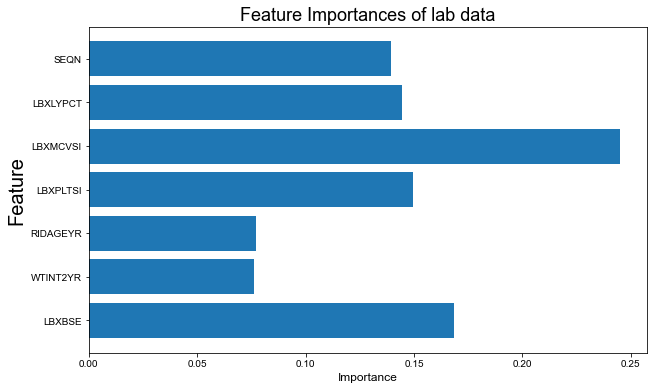

In [51]:
plt.figure(figsize=(10, 6))
plt.barh(importantFeats, importantFeatsSig)
sns.set(font_scale=1.5)
plt.xlabel('Importance', fontsize= 12)
plt.ylabel('Feature', fontsize= 20)
plt.title('Feature Importances of lab data')
plt.gca().invert_yaxis()
plt.show()

Printing out important feats

In [52]:
print(importantFeats)

['SEQN' 'LBXLYPCT' 'LBXMCVSI' 'LBXPLTSI' 'RIDAGEYR' 'WTINT2YR' 'LBXBSE']


In [53]:
for i in combinedLabDataImputed.drop(importantFeats, axis = 1).columns:
    print(i)

LBXWBCSI
LBXMOPCT
LBXEOPCT
LBXBAPCT
LBDLYMNO
LBDMONO
LBDNENO
LBDEONO
LBXRBCSI
LBXHGB
LBXMC
LBXRDW
LBXMPSI
DMDHRAGE
SDMVSTRA
INDHHIN2
LBXBPB
LBXBCD
LBXTHG
LBXBMN
LBXIHG
LBXBGE
LBDHDD
LBXVIDMS
LBXVD2MS
LBXVE3MS
LBDBANO
SDDSRVYR
RIDSTATR
RIAGENDR
RIDRETH1
RIDEXMON
DMDBORN4
DMDCITZN
SIALANG
SIAPROXY
SIAINTRP
FIALANG
FIAPROXY
FIAINTRP
DMDHHSIZ
DMDFMSIZ
DMDHHSZA
DMDHHSZB
DMDHHSZE
DMDHRGND
DMDHRBR4
DMDHREDU
DMDHRMAR
SDMVPSU
LBDBPBLC
LBDBCDLC
LBDTHGLC
LBDBSELC
LBDBMNLC
LBDIHGLC
LBDBGELC
LBDBGMLC
LBDVIDLC
LBDVD2LC
LBDVD3LC
LBDVE3LC


Visualising the correlation between important features

In [54]:
combinedLabDataImputed[importantFeats].describe()

,SEQN,LBXLYPCT,LBXMCVSI,LBXPLTSI,RIDAGEYR,WTINT2YR,LBXBSE
count,12489.000000,12489.000000,12489.000000,12489.000000,12489.000000,12489.000000,12489.000000
mean,93319.094083,34.102218,86.524838,256.941388,33.586356,27819.434462,185.794217
std,5507.873142,10.709199,6.542314,69.425500,17.482578,25722.513937,22.849318
min,83732.000000,3.700000,35.400000,8.000000,1.000000,4878.673923,83.230000
25%,88592.000000,26.800000,82.800000,211.000000,30.000000,20555.854012,173.730000
50%,93271.000000,33.000000,87.100000,249.000000,32.000000,21218.100824,184.350000
75%,98099.000000,40.200000,90.800000,296.000000,34.000000,22069.879904,196.160000
max,102954.000000,94.500000,114.600000,818.000000,80.000000,233755.841850,433.450000


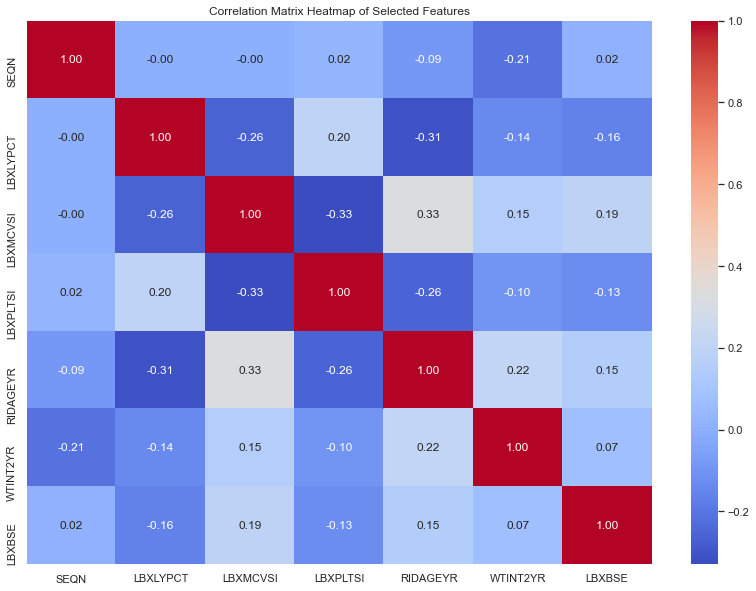

In [55]:
# Drawing the correlation heatmap
corrMatrix = combinedLabDataImputed[importantFeats].corr()
plt.figure(figsize=(14, 10))
sns.set(font_scale=1)
sns.heatmap(corrMatrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix Heatmap of Selected Features')
plt.show()

In [56]:
# sns.pairplot(combinedLabDataImputed[importantFeats])

# Demographic and Environmental data

In [57]:
# Read Complete Blood Count (CBC) 2017-2018
with open('2017-2018/CBC_J.XPT', 'rb') as f:
    df_cbc = pd.read_sas(f, format='xport')

# Read Demographics (DEMO) 2017-2018
with open('2017-2018/DEMO_J.XPT', 'rb') as f:
    df_demo = pd.read_sas(f, format='xport')


# Read Dietary Interview, Total Nutrient Intakes (DR1TOT) 2017-2018
with open('2017-2018/DR1TOT_J.XPT', 'rb') as f:
    df_dr1tot = pd.read_sas(f, format='xport')


# Read Biochemistry profile 2017-2018
with open('2017-2018/BIOPRO_J.XPT', 'rb') as f:
    df_biopro = pd.read_sas(f, format='xport')


# Read Medical Conditions (MCQ) 2017-2018
with open('2017-2018/MCQ_J.XPT', 'rb') as f:
    df_mcq = pd.read_sas(f, format='xport')


# Read Physical Activity (PAQ) 2017-2018
with open('2017-2018/PAQ_J.XPT', 'rb') as f:
    df_paq = pd.read_sas(f, format='xport')


# Read Body Measurements (BMX) 2017-2018
with open('2017-2018/BMX_J.XPT', 'rb') as f:
    df_bmx = pd.read_sas(f, format='xport')

# Read Complete Blood Count (CBC) 2015-2016
with open('2015-2016/CBC_I.XPT', 'rb') as f:
    df_cbc2 = pd.read_sas(f, format='xport')

# Read Demographics (DEMO) 2015-2016
with open('2015-2016/DEMO_I.XPT', 'rb') as f:
    df_demo2 = pd.read_sas(f, format='xport')


# Read Dietary Interview, Total Nutrient Intakes (DR1TOT) 2015-2016
with open('2015-2016/DR1TOT_I.XPT', 'rb') as f:
    df_dr1tot2 = pd.read_sas(f, format='xport')


# Read Biochemistry profile 2015-2016
with open('2015-2016/BIOPRO_I.XPT', 'rb') as f:
    df_biopro2 = pd.read_sas(f, format='xport')


# Read Medical Conditions (MCQ) 2015-2016
with open('2015-2016/MCQ_I.XPT', 'rb') as f:
    df_mcq2 = pd.read_sas(f, format='xport')


# Read Physical Activity (PAQ) 2015-2016
with open('2015-2016/PAQ_I.XPT', 'rb') as f:
    df_paq2 = pd.read_sas(f, format='xport')


# Read Body Measurements (BMX) 2015-2016
with open('2015-2016/BMX_I.XPT', 'rb') as f:
    df_bmx2 = pd.read_sas(f, format='xport')

c:\Users\dl668\anaconda3\lib\site-packages\pandas\io\sas\sas_xport.py:475: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[x] = v


In [58]:
# Assuming the common identifier is 'SEQN'
combined_data17 = pd.merge(df_demo, df_cbc, on='SEQN', how='inner')
combined_data17 = pd.merge(combined_data17, df_dr1tot, on='SEQN', how='inner')
combined_data17 = pd.merge(combined_data17, df_biopro, on='SEQN', how='inner')
combined_data17 = pd.merge(combined_data17, df_mcq, on='SEQN', how='inner')
combined_data17 = pd.merge(combined_data17, df_paq, on='SEQN', how='inner')
combined_data17 = pd.merge(combined_data17, df_bmx, on='SEQN', how='inner')

combined_data15 = pd.merge(df_demo2, df_cbc2, on='SEQN', how='inner')
combined_data15 = pd.merge(combined_data15, df_dr1tot2, on='SEQN', how='inner')
combined_data15 = pd.merge(combined_data15, df_biopro2, on='SEQN', how='inner')
combined_data15 = pd.merge(combined_data15, df_mcq2, on='SEQN', how='inner')
combined_data15 = pd.merge(combined_data15, df_paq2, on='SEQN', how='inner')
combined_data15 = pd.merge(combined_data15, df_bmx2, on='SEQN', how='inner')
#Summary statistics 
combined_data = combined_data15.append(combined_data17, ignore_index = True)
combined_data = combined_data.reset_index()
combined_data = combined_data.drop(['index'], axis=1)
display(combined_data.describe().round(2)) 

,SEQN,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,...,MCQ366A,MCQ366B,MCQ366C,MCQ366D,MCQ371A,MCQ371B,MCQ371C,MCQ371D,BMXHIP,BMIHIP
count,12277.00,12277.00,12277.0,12277.00,12277.00,0.0,12277.00,12277.00,12277.00,1522.00,...,5533.00,5533.00,5533.0,5533.00,5533.00,5533.00,5533.00,5533.00,5198.00,251.0
mean,93023.13,9.45,2.0,1.52,46.09,NaN,3.14,3.36,1.51,195.97,...,1.72,1.59,1.7,1.68,1.38,1.42,1.44,1.42,106.80,1.0
std,5519.10,0.50,0.0,0.50,20.15,NaN,1.29,1.66,0.50,28.32,...,0.47,0.50,0.5,0.51,0.51,0.52,0.54,0.55,14.59,0.0
min,83732.00,9.00,2.0,1.00,12.00,NaN,1.00,1.00,1.00,144.00,...,1.00,1.00,1.0,1.00,1.00,1.00,1.00,1.00,74.70,1.0
25%,88282.00,9.00,2.0,1.00,29.00,NaN,2.00,2.00,1.00,172.00,...,1.00,1.00,1.0,1.00,1.00,1.00,1.00,1.00,96.60,1.0
50%,92815.00,9.00,2.0,2.00,46.00,NaN,3.00,3.00,2.00,198.00,...,2.00,2.00,2.0,2.00,1.00,1.00,1.00,1.00,104.20,1.0
75%,97716.00,10.00,2.0,2.00,63.00,NaN,4.00,4.00,2.00,222.00,...,2.00,2.00,2.0,2.00,2.00,2.00,2.00,2.00,114.10,1.0
max,102956.00,10.00,2.0,2.00,80.00,NaN,5.00,7.00,2.00,239.00,...,9.00,9.00,9.0,9.00,9.00,9.00,9.00,9.00,179.00,1.0


In [59]:
# Calculate the threshold for half of the instances
threshold = len(combined_data) / 2

# Drop columns where number of non-NA values is less than the threshold
combined_data.dropna(thresh=threshold, axis=1, inplace=True)

combined_data

,SEQN,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDRETH1,RIDRETH3,RIDEXMON,DMQMILIZ,DMDBORN4,...,BMXWT,BMXHT,BMXBMI,BMXLEG,BMXARML,BMXARMC,BMXWAIST,BMXSAD1,BMXSAD2,BMDAVSAD
0,83732.0,9.0,2.0,1.0,62.0,3.0,3.0,1.0,2.0,1.0,...,94.8,184.5,27.8,43.3,43.6,35.9,101.1,22.9,22.7,22.8
1,83733.0,9.0,2.0,1.0,53.0,3.0,3.0,1.0,2.0,2.0,...,90.4,171.4,30.8,38.0,40.0,33.2,107.9,27.5,27.1,27.3
2,83734.0,9.0,2.0,1.0,78.0,3.0,3.0,2.0,1.0,1.0,...,83.4,170.1,28.8,35.6,37.0,31.0,116.5,26.7,26.5,26.6
3,83735.0,9.0,2.0,2.0,56.0,3.0,3.0,2.0,2.0,1.0,...,109.8,160.9,42.4,38.5,37.7,38.3,110.1,25.2,25.0,25.1
4,83736.0,9.0,2.0,2.0,42.0,4.0,4.0,2.0,2.0,1.0,...,55.2,164.9,20.3,37.4,36.0,27.2,80.4,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12272,102949.0,10.0,2.0,1.0,33.0,3.0,3.0,2.0,2.0,1.0,...,76.9,180.1,23.7,45.2,41.0,32.9,85.5,NaN,NaN,NaN
12273,102952.0,10.0,2.0,2.0,70.0,5.0,6.0,2.0,2.0,2.0,...,49.0,156.5,20.0,34.4,32.6,25.1,82.2,NaN,NaN,NaN
12274,102953.0,10.0,2.0,1.0,42.0,1.0,1.0,2.0,2.0,2.0,...,97.4,164.9,35.8,38.2,36.6,40.6,114.8,NaN,NaN,NaN
12275,102954.0,10.0,2.0,2.0,41.0,4.0,4.0,1.0,2.0,1.0,...,69.1,162.6,26.1,39.2,35.2,26.8,86.4,NaN,NaN,NaN


In [60]:
# Remove rows where 'MCQ053' is either 7 or 9
combined_data = combined_data[combined_data['MCQ053'].isin([1, 2]) == True]

combined_data

,SEQN,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDRETH1,RIDRETH3,RIDEXMON,DMQMILIZ,DMDBORN4,...,BMXWT,BMXHT,BMXBMI,BMXLEG,BMXARML,BMXARMC,BMXWAIST,BMXSAD1,BMXSAD2,BMDAVSAD
0,83732.0,9.0,2.0,1.0,62.0,3.0,3.0,1.0,2.0,1.0,...,94.8,184.5,27.8,43.3,43.6,35.9,101.1,22.9,22.7,22.8
1,83733.0,9.0,2.0,1.0,53.0,3.0,3.0,1.0,2.0,2.0,...,90.4,171.4,30.8,38.0,40.0,33.2,107.9,27.5,27.1,27.3
2,83734.0,9.0,2.0,1.0,78.0,3.0,3.0,2.0,1.0,1.0,...,83.4,170.1,28.8,35.6,37.0,31.0,116.5,26.7,26.5,26.6
3,83735.0,9.0,2.0,2.0,56.0,3.0,3.0,2.0,2.0,1.0,...,109.8,160.9,42.4,38.5,37.7,38.3,110.1,25.2,25.0,25.1
4,83736.0,9.0,2.0,2.0,42.0,4.0,4.0,2.0,2.0,1.0,...,55.2,164.9,20.3,37.4,36.0,27.2,80.4,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12272,102949.0,10.0,2.0,1.0,33.0,3.0,3.0,2.0,2.0,1.0,...,76.9,180.1,23.7,45.2,41.0,32.9,85.5,NaN,NaN,NaN
12273,102952.0,10.0,2.0,2.0,70.0,5.0,6.0,2.0,2.0,2.0,...,49.0,156.5,20.0,34.4,32.6,25.1,82.2,NaN,NaN,NaN
12274,102953.0,10.0,2.0,1.0,42.0,1.0,1.0,2.0,2.0,2.0,...,97.4,164.9,35.8,38.2,36.6,40.6,114.8,NaN,NaN,NaN
12275,102954.0,10.0,2.0,2.0,41.0,4.0,4.0,1.0,2.0,1.0,...,69.1,162.6,26.1,39.2,35.2,26.8,86.4,NaN,NaN,NaN


In [61]:
# Separating numerical and categorical columns
numerical_cols = [col for col in combined_data.columns if ('LBX' in col or 'BMX' in col or 'LBD' in col)]
categorical_cols = [col for col in combined_data.columns if ('MCQ' in col or 'PAQ' in col or 'OSQ' in col or 'BMDSTATS' in col or 'DMDHRGND' in col)]

# Adding 'SEQN' to both lists as it is common in both and is more of an identifier
numerical_cols.append('SEQN')
categorical_cols.append('SEQN')

# Create datasets using the separated columns
numerical_data = combined_data[numerical_cols]
categorical_data = combined_data[categorical_cols]

print(numerical_data)
print(categorical_data)

       LBXWBCSI  LBXLYPCT  LBXMOPCT  LBXNEPCT  LBXEOPCT  LBXBAPCT  LBDLYMNO  \
0           9.8      23.9       8.2      63.5       4.0       0.5       2.3   
1           7.3      31.3       9.7      54.8       2.6       1.8       2.3   
2           4.4      29.9       9.6      55.8       3.9       0.9       1.3   
3           6.1      17.1      10.3      68.7       3.1       0.9       1.0   
4           4.2      47.1       7.8      44.8       0.2       0.2       2.0   
...         ...       ...       ...       ...       ...       ...       ...   
12272       9.0      29.8       8.8      59.0       2.2       0.4       2.7   
12273       5.1      34.9       7.1      56.2       1.3       0.6       1.8   
12274       8.3      28.3       6.8      60.8       3.6       0.6       2.3   
12275       5.1      43.5      11.8      39.9       3.5       1.4       2.2   
12276       9.0      29.4       6.9      58.8       4.0       1.0       2.6   

       LBDMONO  LBDNENO       LBDEONO  ...  BMXWT  

In [62]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Create an imputer object with a median filling strategy
imputer_num = SimpleImputer(strategy='median')

# Apply the imputer to the numerical data
numerical_data_imputed = pd.DataFrame(imputer_num.fit_transform(numerical_data), columns=numerical_data.columns)

# Impute missing values with the mode for each column
categorical_data_imputed = categorical_data.apply(lambda x: x.fillna(x.mode()[0]), axis=0)

print(numerical_data_imputed) #no scaling 
print(categorical_data_imputed)

       LBXWBCSI  LBXLYPCT  LBXMOPCT  LBXNEPCT  LBXEOPCT  LBXBAPCT  LBDLYMNO  \
0           9.8      23.9       8.2      63.5       4.0       0.5       2.3   
1           7.3      31.3       9.7      54.8       2.6       1.8       2.3   
2           4.4      29.9       9.6      55.8       3.9       0.9       1.3   
3           6.1      17.1      10.3      68.7       3.1       0.9       1.0   
4           4.2      47.1       7.8      44.8       0.2       0.2       2.0   
...         ...       ...       ...       ...       ...       ...       ...   
12256       9.0      29.8       8.8      59.0       2.2       0.4       2.7   
12257       5.1      34.9       7.1      56.2       1.3       0.6       1.8   
12258       8.3      28.3       6.8      60.8       3.6       0.6       2.3   
12259       5.1      43.5      11.8      39.9       3.5       1.4       2.2   
12260       9.0      29.4       6.9      58.8       4.0       1.0       2.6   

       LBDMONO  LBDNENO       LBDEONO  ...  BMXWT  

In [63]:
# import matplotlib.pyplot as plt

# # Loop through each numerical column and plot a histogram
# for column in numerical_data_imputed.columns:
#     plt.figure()
#     plt.hist(numerical_data_imputed[column], bins=30, edgecolor='black')
#     plt.title(f"Histogram of {column}")
#     plt.xlabel(column)
#     plt.ylabel("Frequency")
#     plt.show()


In [64]:
# import seaborn as sns

# # Loop through each categorical column and plot a bar chart
# for column in categorical_data_imputed.columns:
#     plt.figure()
#     sns.countplot(data=categorical_data_imputed, x=column)
#     plt.title(f"Bar Chart of {column}")
#     plt.xlabel(column)
#     plt.ylabel("Count")
#     plt.show()


In [65]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import pandas as pd

# Function to diagnose anemia
def diagnose_anemia(rbc, hgb, hct):
    if rbc < 4.5 or hgb < 12 or hct < 36:
        return 1
    else:
        return 0

# Assuming numerical_data_imputed and categorical_data_imputed already exist
# Re-create the Anemia column after imputation
numerical_data_imputed['Anemia'] = numerical_data_imputed.apply(
    lambda row: diagnose_anemia(row.get('LBXRBCSI', 0), row.get('LBXHGB', 0), row.get('LBXHCT', 0)), axis=1)

# Combine numerical and categorical data back into one DataFrame
combined_data_imputed = pd.concat([numerical_data_imputed, categorical_data_imputed], axis=1)

# Impute any remaining missing values
imputer = SimpleImputer(strategy='most_frequent')
combined_data_imputed = pd.DataFrame(imputer.fit_transform(combined_data_imputed), columns=combined_data_imputed.columns)

# Seperate data for later use
combined_data_imputed, combined_data_imputed_final_test = train_test_split(combined_data_imputed, test_size = 0.2, random_state=69)
combined_data_imputed = combined_data_imputed.reset_index().drop('index', axis=1)
combined_data_imputed_final_test = combined_data_imputed_final_test.reset_index().drop('index', axis=1)
combined_data_imputed_final_test.to_csv('combined_data_imputed_final_test.csv', sep=',', index=False, encoding='utf-8')
# Separate out the features and target variable
features = combined_data_imputed.columns.drop(['Anemia', 'LBXRBCSI', 'LBXHGB', 'LBXHCT'])  
X = combined_data_imputed[features]
y = combined_data_imputed['Anemia']

# Splitting data (again)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit a RandomForest classifier
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Get feature importances
importances = clf.feature_importances_

# Map feature importances to their respective feature names
feature_importances = dict(zip(features, importances))

# Sort the feature importances
sorted_feature_importances = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)

# Decide on a threshold for feature importance
threshold = 0.01  # Change this value based on your specific needs

# Features to include and exclude
features_to_include = [feature for feature, importance in sorted_feature_importances if importance >= threshold]
features_to_exclude = [feature for feature, importance in sorted_feature_importances if importance < threshold]

# Print the features to include and exclude
print("Features to Include:")
print(features_to_include)

print("\nFeatures to Exclude:")
print(features_to_exclude)

Features to Include:
['LBXMCVSI', 'LBXMCHSI', 'BMXHT', 'LBXSATSI', 'LBXSIR', 'LBDSIRSI', 'LBDSUASI', 'LBXRDW', 'LBDSALSI', 'LBXSUA', 'LBXSAL', 'LBXSAPSI', 'LBDSCRSI', 'LBXMC', 'BMXLEG', 'BMXARML', 'BMXWT', 'LBXSCR', 'LBXPLTSI', 'BMXARMC', 'LBXSGTSI', 'LBXWBCSI', 'LBDSBUSI', 'LBXSCK', 'LBXLYPCT', 'LBXSBU', 'BMXWAIST', 'LBXSLDSI', 'LBDLYMNO', 'LBXSKSI', 'LBDSCHSI', 'LBXMOPCT', 'LBDSCASI', 'LBXEOPCT', 'LBXSTR', 'LBXNEPCT', 'LBDSTRSI', 'LBDNENO', 'LBXSCH', 'LBXSASSI', 'LBXMPSI', 'LBXSOSSI', 'LBXSGL', 'BMXBMI', 'LBXSCA', 'LBXSTP']

Features to Exclude:
['DMDHRGND', 'LBDSGLSI', 'LBDSTPSI', 'LBDSGBSI', 'LBXSGB', 'LBXSCLSI', 'LBXSPH', 'LBDSTBSI', 'LBXSTB', 'LBXBAPCT', 'LBDSPHSI', 'LBXSNASI', 'LBXSC3SI', 'BMXSAD1', 'LBDMONO', 'BMXSAD2', 'LBDEONO', 'PAQ715', 'BMDSTATS', 'LBDBANO', 'MCQ300B', 'MCQ092', 'MCQ300C', 'OSQ230', 'PAQ665', 'MCQ160A', 'SEQN', 'MCQ010', 'PAQ635', 'PAQ605', 'PAQ710', 'MCQ160N', 'PAQ650', 'MCQ160K', 'PAQ620', 'MCQ300A', 'MCQ053', 'MCQ160O', 'MCQ160D', 'MCQ080', 'MCQ160L', '

In [66]:
len(combined_data_imputed_final_test)

2456

Correlation Matrix:
          LBXMCVSI  LBXMCHSI     BMXHT  LBXSATSI    LBXSIR  LBDSIRSI  \
LBXMCVSI  1.000000  0.952927  0.061984  0.044606  0.327267  0.327305   
LBXMCHSI  0.952927  1.000000  0.095870  0.080326  0.367969  0.368006   
BMXHT     0.061984  0.095870  1.000000  0.140859  0.149694  0.149816   
LBXSATSI  0.044606  0.080326  0.140859  1.000000  0.135668  0.135629   
LBXSIR    0.327267  0.367969  0.149694  0.135668  1.000000  0.999990   
LBDSIRSI  0.327305  0.368006  0.149816  0.135629  0.999990  1.000000   
LBDSUASI  0.025499  0.050899  0.292146  0.198122  0.093133  0.093211   
LBXRDW   -0.476685 -0.556099 -0.071884 -0.082601 -0.332906 -0.332909   
LBDSALSI  0.041987  0.084680  0.177023  0.103385  0.206694  0.206646   

          LBDSUASI    LBXRDW  LBDSALSI  
LBXMCVSI  0.025499 -0.476685  0.041987  
LBXMCHSI  0.050899 -0.556099  0.084680  
BMXHT     0.292146 -0.071884  0.177023  
LBXSATSI  0.198122 -0.082601  0.103385  
LBXSIR    0.093133 -0.332906  0.206694  
LBDSIRSI  0.0

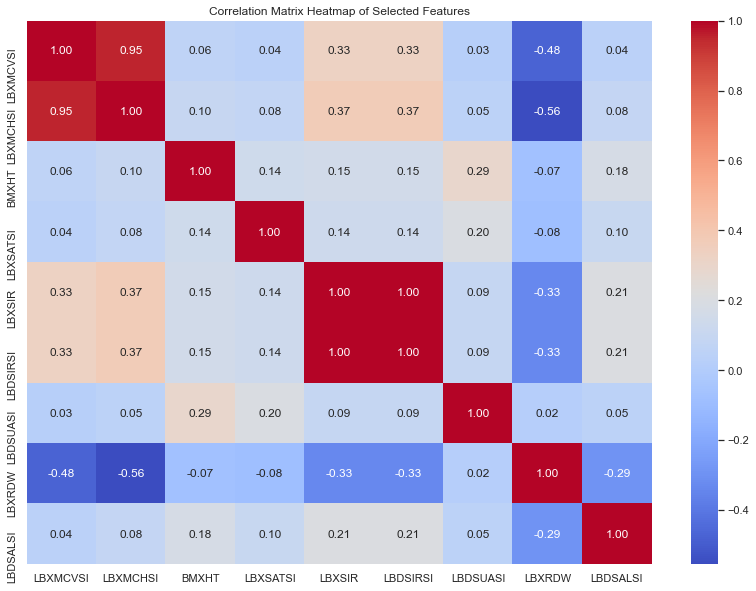

In [69]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming that combined_data is your DataFrame that contains all these columns
# Replace 'combined_data' with your actual DataFrame containing the selected features
selected_features = ['LBXMCVSI', 'LBXMCHSI', 'BMXHT', 'LBXSATSI', 'LBXSIR', 'LBDSIRSI', 'LBDSUASI', 'LBXRDW', 'LBDSALSI']

# Correlation matrix of selected features
correlation_matrix = combined_data[selected_features].corr()

# Print the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

# Correlation with target variable 'Anaemia' if it's in your dataset
# Uncomment the following lines if you have the 'Anaemia' column in your combined_data DataFrame
#correlation_with_target = combined_data.corr()['Anemia'].sort_values(ascending=False)
#print("\nCorrelation with Target (Anaemia):")
#print(correlation_with_target)

# Heatmap of the correlation matrix
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix Heatmap of Selected Features')
plt.show()